## Graph Coloring

We are given an undirected graph $G=(V,E)$ where $V$ is the set of vertices and $E$ is the set of edges. Given $n$ colors, is it possible to color the graph such that no two adjacent vertices have the same color. It is a NP-Complete problem as it's a generalization of the NP-Hard problem, how many colors are needed to color the graph in the respective manner. 

We use networkx and matplotlib to create and display the graph.

## QUBO Hamiltonian

$n$ is the number of vertices and $m$ is the number of colors.
We take a binary variable $x_{v,i}$ for each element in a vertex-color matrix. Thus the total number of qubits that will be used are $n*m$.

We have two main constraints:
1. Every vertex should be represented by only one color.

$$ H_A = \sum_{v} (1 - \sum_{i=1}^{m} q_{v,i})^2 $$

2. Adjacent vertices should have different colours.

$$ H_B = \sum_{(uv) \in E}^{n} \sum_{i=1}^{m} q_{u,i}*q_{v,i} $$



## Example

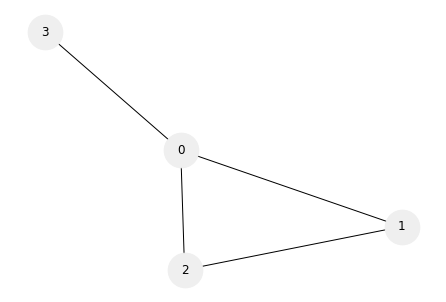

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

n = 4 #number of nodes
m = 3 #number of colors

G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2)])
nx.draw(G, **options)

In [4]:
from blueqat.utils import qaoa
from blueqat.pauli import qubo_bit as q
import numpy as np

#make an adjacent matrix
a = nx.to_numpy_matrix(G)
    
b = np.zeros((n,m), dtype=int)

my_dict = {}

num = 0
for v in range(n):
    for i in range(m):
        b[v][i] = num
        my_dict[num]=[str(v),i]
        num+=1
        
        


h_1= 0.0
const_h = 0.0
for v in range (n):
    for i in range(m):
        const_h = const_h + q(b[v,i])
        
    h_1 = h_1 + (1 - const_h)**2
    const_h = 0.0
        
h_2 = 0.0    
for u in range(n):
    for v in range(n):
        for i in range(m):
            if(a[u,v]==1):
                h_2 = h_2 + q(b[u,i])*q(b[v,i])
                
h = h_1 + h_2

In [5]:
step = 2

result = qaoa(h, step)
b = result.circuit.run(shots=10)
sample = b.most_common(1)[0][0]
print("sample:"+ str(sample))

sample:011110101111


In [6]:
for i in range(n*m):
    if(list(sample)[i]==1):
        print(my_dict[i])

### Graph Partitioning

We are given a graph $G = (V,E)$ with $V$ being the vertex set and $E$ being the edges set. The aim of the graph partitioning problem is to divide the graph into two subsets with equal number of vertices or size such that the edges connecting both the vertices are minimum. If we look carefully this problem is kind of opposite to the max cut problem but with fixed subset sizes.

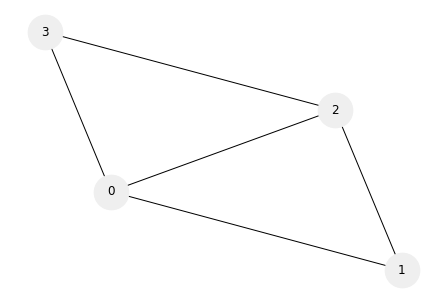

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

n = 4

G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2),(2,3)])
nx.draw(G, **options)

When we are creating the Hamiltionian for the above problem, we take into consideration the constarint that both the subsets have equal number of vertices.
Thus the constraint : 
$$ H_C = A(\sum^N_{n=1} s_i)^2 $$

The cost hamiltonian which minimizes the edges between both the subsets is:
$$ H_A = B\sum_{uv \in E} \frac{1 - \sigma_u \sigma_v}{2}$$

The total hamiltonian comes out to be $H = H_A+H_C$.

Reference: https://arxiv.org/abs/1302.5843

In [8]:
from blueqat.utils import qaoa
from blueqat.pauli import *
import numpy as np

a = np.zeros((n), dtype=int)

b = np.zeros((n,n), dtype=int)

for k in G.edges:
    b[k[0]][k[1]] = 1

In [9]:
h_1 = 0.0
for i in range(n):
    h_1+= Z(i)
    
h_1 = h_1**2


h_2 = 0.0

for i in range(n):
    for j in range(n):
        if(b[i,j]==1):
            h_2+= (1-Z(i)*Z(j))/2

h = h_1*100 + h_2

In [10]:
step = 2

result = qaoa(h, step)
b = result.circuit.run(shots=10)
sample = b.most_common(1)[0][0]
print("sample:"+ str(sample))

sample:1010
